## import some libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import time
import os
import glob
import matplotlib.pyplot as plt
import cv2
from itertools import combinations

## load the model and the image

In [ ]:
weights_path =os.path.join("/content/drive/MyDrive/project_data/yolov3.weights")
cfg_path =os.path.join("/content/drive/MyDrive/project_data/yolov3.cfg.txt")
net=cv2.dnn.readNetFromDarknet(cfg_path ,weights_path)
image_path =os.path.join("/content/test6.JPG")
img = plt.imread(image_path)

## Car_Accident_function

In [ ]:
def car_accident(img) :
  (H,W)=img.shape[:2]
  blob= cv2.dnn.blobFromImage(img,1/255.0,(416,416),crop=False,swapRB=False)
  net.setInput(blob)
  layers_output=net.forward(['yolo_82', 'yolo_94', 'yolo_106'])
  car_boxes=[]
  car_confidences=[]
  classIDs=[]
  for output in layers_output:
    for detection in output:
        scores=detection[5:]
        classID=np.argmax(scores)
        confidence=scores[classID]
        if classID==2:
          if (confidence >0.5):
            box=detection[:4] * np.array([W,H,W,H])
            bx,by,bw,bh=box.astype("int")
            x=int(bx-(bw/2))
            y=int(by-(bh/2))
            car_boxes.append([x,y,int(bw),int(bh)])
            car_confidences.append(float(confidence))
            classIDs.append(classID)
  car_idx=cv2.dnn.NMSBoxes(car_boxes,car_confidences,0.4,0.6)

  if len(car_idx) > 0:  						# At least 1 detection in the image and check detection presence in a frame
        centroid_dict = dict() 						# Function creates a dictionary and calls it centroid_dict
        objectId = 0								# We inialize a variable called ObjectId and set it to 0
        for i in car_idx.flatten():
          (x,y)=[car_boxes[i][0],car_boxes[i][1]]
          (w,h)=[car_boxes[i][2],car_boxes[i][3]]

     	    # Store the center points of the detections
          # Convert from center coordinates to rectangular coordinates, We use floats to ensure the precision of the BBox
          xmin = int(round(x))
          xmax = int(xmin+w)
          ymin = int(round(y))
          ymax = int(ymin+h)

          # Append center point of bbox for cars detected.
          centroid_dict[objectId] = (int(x), int(y), xmin, ymin, xmax, ymax) # Create dictionary of tuple with 'objectId' as the index center points and bbox
          objectId += 1 #Increment the index for each detection
    #=================================================================#
    # Purpose : Determine which car bbox are close to each other
    #=================================================================
        vehicle_red_zone_list = [] # List containing which Object id is in under threshold distance condition.
        vehicle_red_line_list = []
        for (id1, p1), (id2, p2) in combinations(centroid_dict.items(), 2): # Get all the combinations of close detections, #List of multiple items - id1 1, points 2, 1,3
            #dx, dy = p1[0] - p2[0], p1[1] - p2[1]  	# Check the difference between centroid x: 0, y :1
            #distance = is_close(dx, dy) 			# Calculates the Euclidean distance

            #if distance < 50.0:						# Set our distance threshold - If they meet this condition then..

            if not ((p1[2]+30>=p2[4]) or (p1[4]<=p2[2]+30) or (p1[5]<=p2[3]+30) or (p1[3]+30>=p2[5])):
                if id1 not in vehicle_red_zone_list:
                    vehicle_red_zone_list.append(id1)       #  Add Id to a list
                    vehicle_red_line_list.append(p1[0:2])   #  Add points to the list
                if id2 not in vehicle_red_zone_list:
                    vehicle_red_zone_list.append(id2)		# Same for the second id
                    vehicle_red_line_list.append(p2[0:2])

        for idx1, box in centroid_dict.items():  # dict (1(key):red(value), 2 blue)  idx - key  box - value
            if idx1 in vehicle_red_zone_list:   # if id is in red zone list
                cv2.rectangle(img, (box[2], box[3]), (box[4], box[5]), (255, 0, 0), 2) # Create Red bounding boxes  #starting point, ending point size of 2
            else:
                cv2.rectangle(img, (box[2], box[3]), (box[4], box[5]), (0, 255, 0), 2) # Create Green bounding boxes
		#=================================================================#

        if len(vehicle_red_zone_list)!=0:
            text = "Crash Detected"
        else:
            text = "Crash Not Detected"

        location = (W-500,100)										# Set the location of the displayed text
        if len(vehicle_red_zone_list)!=0:
            cv2.putText(img, text, location, cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 2, cv2.LINE_AA)  # Display Text
        else:
            cv2.putText(img, text, location, cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2, cv2.LINE_AA)  # Display Text
  return img

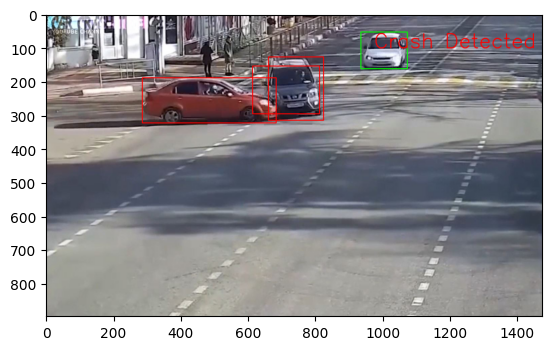

In [ ]:
image=car_accident(img)
plt.imshow(image)